In [ ]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
cpuCount = os.cpu_count()

# Print the number of CPUs in the system
print("Number of CPUs in the system:", cpuCount)

Number of CPUs in the system: 8


In [ ]:
%%script bash
lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   45 bits physical, 48 bits virtual
CPU(s):                          8
On-line CPU(s) list:             0-7
Thread(s) per core:              1
Core(s) per socket:              2
Socket(s):                       4
NUMA node(s):                    1
Vendor ID:                       AuthenticAMD
CPU family:                      23
Model:                           24
Model name:                      AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx
Stepping:                        1
CPU MHz:                         2096.062
BogoMIPS:                        4192.12
Hypervisor vendor:               VMware
Virtualization type:             full
L1d cache:                       256 KiB
L1i cache:                       512 KiB
L2 cache:                        4 MiB
L3 cache:                        4 MiB
NUMA node0 CPU(s):               

**Sequential computation of LU Decomposition**

In [ ]:
%%writefile sequential.cpp

#include <bits/stdc++.h>

using namespace std;
using namespace chrono;

#define forn(i,n) for(int i=0; i < n; i++)

int n;
ofstream output, times;
double delta = 0.000000001;                            // very small value

/////////////////////////////////////// INTIALIZATION AND ALLOCATION OF MATRICES ///////////////////////////////////////

double **create_matrix()
{
    double **m = (double**)malloc(n * sizeof(double*));             
    forn(i,n){
        m[i] = (double*)malloc(n * sizeof(double));  // allocating memory of n x n to matrix, initializing with 0's
        forn(j, n)
            m[i][j] = 0.0;
    }

    return m;
}

void initialize_A(double** A, double** Areal)
{                                                      // initializing the input matrix, making a copy for future reference
    forn(i,n)
        forn(j,n){
            A[i][j] = drand48() * 100;
            
            Areal[i][j] = A[i][j];                     // Keeping a copy of the original matrix (before its modified)
        }
}

void initialize_L(double** L)
{                                                      // initializing the lower triangular matrix
    forn(i,n)
        forn(j,n)
            if(i > j)
                L[i][j] = drand48() * 100;
            else if(i == j)
                L[i][j] = 1.0;
}

void initialize_U(double** U)
{                                                      // initializing the upper triangular matrix
    forn(i,n)
        forn(j,n)
            if(i <= j)
                U[i][j] = drand48() * 100;
}

void freeMemory(double** matrix)
{                                                   // deleting all variables with significant memory size
    forn(i,n)
        delete[] matrix[i];
    delete[] matrix;
}

/////////////////////////////////////////////// MATRIX MULTIPLICATION AND VERIFICATION //////////////////////////////////////////

double calculate_residue(double** P, double** A, double** L, double** U)
{                                                   // returns the variance of matrix ( PA - LU ) for finding error magnitude
    double res = 0.0, res1;

    forn(i,n)
        forn(j,n){
            res1= 0.0;
            forn(k,n)
                res1 += P[i][k] * A[k][j] - L[i][k] * U[k][j] ;
            res += res1 * res1;
        }

    return res;
}

string mulMat(double **mat1, double **mat2, int N) {
    double rslt[N][N];
    ostringstream ss;
    ss<< endl;
 
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            rslt[i][j] = 0;
 
            for (int k = 0; k < N; k++) {
                rslt[i][j] += mat1[i][k] * mat2[k][j];
            }
 
            ss<< rslt[i][j] << " ";
        }
 
        ss<< endl;
    }
    return ss.str();
}

//////////////////////////////////////////////// PRINTING AND OUTPUT TO FILE /////////////////////////////////////////////

string print_matrix(double** matrix)
{
    ostringstream ss;                                                     // printing given matrix
    forn(i,n){
        forn(j,n)
            ss << matrix[i][j] << " ";
        ss << endl;
    }
    return ss.str();
}

void output_to_file(double **Areal, double **L, double **U, double **P, int *pi, string time_taken)
{
    //Feed all the matrices output file
    output.open("out_"+to_string(n)+"_"+"seq.txt");    

    output<<"This output file contains output for: "<<endl;
    output<<"Matrix size: "<<to_string(n)<<"x"<<to_string(n)<<endl;
    output<<time_taken<<endl;
    output<<endl<<"Matrix A- "<<endl<<print_matrix(Areal);
    output<<endl<<"Matrix U- "<<endl<<print_matrix(U);
    output<<endl<<"Matrix L- "<<endl<<print_matrix(L);
    output<<endl<<"Matrix P- "<<endl<<print_matrix(P);

    ostringstream ss;
    ss<<"Permute vector: "<<endl;
    forn(i,n)
        ss<<pi[i]<<" ";
    output<<ss.str();


    output<<endl<<"Verify matrix multiplication of LU: "<<endl<<mulMat(L, U, n);
}

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

void lu_decomposition()
{
    int* pi = (int*)malloc(n * sizeof(int));
    double** P = create_matrix(),**A = create_matrix(),
        **Areal = create_matrix(),**U = create_matrix(),**L = create_matrix();

    initialize_A(A,Areal);
    initialize_U(U);
    initialize_L(L);

    auto t1 = high_resolution_clock::now();        // starting timer

    forn(i,n)
        pi[i] = i;                                 // initialize pi as a vector of length n

    
    forn(k,n)
    {
        double max_A = 0.0;                        // max value below (including) main diagonal in k-th row of A    * PIVOT *
        int k1 = -1;                               // row index of this max value

        for(int i=k; i < n; i++)
            if(max_A < abs(A[i][k]))
            {
                max_A = abs(A[i][k]);
                k1 = i;
            }

        if(abs(max_A)<delta)                       // raise an error for the matrix being singular
            perror("received singular matrix A");

        swap(pi[k], pi[k1]);
        swap(A[k], A[k1]);                         // swap k-th row with k1-th

        forn(m,k)
            swap(L[k][m], L[k1][m]);

        U[k][k] = A[k][k];

        for(int i=k+1; i < n; i++)
        {
            L[i][k] = A[i][k]/(U[k][k]+delta);     // dividing A(k+1:n,k) by pivot and copying to L(k+1:n,k)
            U[k][i] = A[k][i];                     // copying A(k,k+1:n) to U(k,k+1:n)
        }
        int i;
                                                   
        for(i=k+1; i < n; i++)
        {
            for(int j=k+1; j < n; j++)
            {
                A[i][j] -= L[i][k]*U[k][j];   // decrementing A(k+1:n,k+1:n) by [ L(k+1:n,k) ]*[ U(k,k+1:n) ]'
            }
        }
    }

    auto t2 = high_resolution_clock::now();       // ending timer

    forn(i,n)
        P[i][pi[i]] = 1.0;                        // converting pi into a 2D array by replacing pi[i] with its one hot embedding.

    //Printing output to terminal
    double residue = calculate_residue(P, Areal, L, U);
    cout << "time taken by Sequential LU decomposition: " << 
    duration_cast<microseconds>( t2 - t1 ).count()<<" micro seconds"<<endl; // printing the time taken (in seconds)
    cout<<"Residue: "<<fixed<<setprecision(18)<<residue<<endl;
    //cout<<print_matrix(Areal)<<endl;
    //cout<<print_matrix(P)<<endl;
    //cout<<print_matrix(L)<<endl;
    //cout<<print_matrix(U)<<endl;


    //Creating output stream to insert into file
    ostringstream temp;
    temp << "time taken by Sequential LU decomposition: " << 
    duration_cast<microseconds>( t2 - t1 ).count()<<" micro seconds"<<endl;
    string time_taken = temp.str();

    //Feed all matrices to output.txt file
    //output_to_file(Areal, L, U, P, pi, time_taken);

    // Store only time taken into separate file
    times.open("openMP_times.txt", std::ios_base::app); // append instead of overwrite
    times<<n<<" 0"<<" "<<duration_cast<microseconds>( t2 - t1 ).count()<<endl;

    freeMemory(P);                                // deleting all variables with significant memory size
    freeMemory(A);
    freeMemory(Areal);
    freeMemory(L);
    freeMemory(U);
    delete [] pi;
}

int main(int argc, char* argv[])
{
    n = stoi(argv[1]);

    //srand48((unsigned int) time(nullptr));        // seed for pseudo-random number generator

    lu_decomposition();   

    return 0;
}

Overwriting sequential.cpp


**Parallel Computation of LU decomposition using OpenMP library**

In [ ]:
%%writefile openMP.cpp

#include <bits/stdc++.h>
#include <omp.h>

using namespace std;
using namespace chrono;

#define forn(i,n) for(int i=0; i < n; i++)

int n, num_thread;
ofstream output, times;
double delta = 0.000000001;                            // very small value


////////////////////////////////////////////////  INITIALIZATION FUNCTIONS  /////////////////////////////////////////////

double **create_matrix()
{
    double **m = (double**)malloc(n * sizeof(double*));             
    forn(i,n){
        m[i] = (double*)malloc(n * sizeof(double));  // allocating memory of n x n to matrix, initializing with 0's
        forn(j, n)
            m[i][j] = 0.0;
    }

    return m;
}

void initialize_A(double** A, double** Areal)
{                                                      // initializing the input matrix, making a copy for future reference
    forn(i,n)
        forn(j,n){
            A[i][j] = drand48() * 100;
            
            Areal[i][j] = A[i][j];                     // Keeping a copy of the original matrix (before its modified)
        }
}

void initialize_L(double** L)
{                                                      // initializing the lower triangular matrix
    forn(i,n)
        forn(j,n)
            if(i > j)
                L[i][j] = drand48() * 100;
            else if(i == j)
                L[i][j] = 1.0;
}

void initialize_U(double** U)
{                                                      // initializing the upper triangular matrix
    forn(i,n)
        forn(j,n)
            if(i <= j)
                U[i][j] = drand48() * 100;
}

void freeMemory(double** matrix)
{                                                   // deleting all variables with significant memory size
    forn(i,n)
        delete[] matrix[i];
    delete[] matrix;
}

///////////////////////////////////////////////////// MATRIX MULTIPLICATION FOR VERIFACTION /////////////////////////////////////////////////
string mulMat(double **mat1, double **mat2, int N) {
    double rslt[N][N];
    ostringstream ss;
    ss<< endl;
 
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            rslt[i][j] = 0;
 
            for (int k = 0; k < N; k++) {
                rslt[i][j] += mat1[i][k] * mat2[k][j];
            }
 
            ss<< rslt[i][j] << " ";
        }
 
        ss<< endl;
    }
    return ss.str();
}

///////////////////////////////////////////////////// PRINTING AND OUTPUT TO FILE /////////////////////////////////////////////////

string print_matrix(double** matrix)
{
    ostringstream ss;                                                     // printing given matrix
    forn(i,n){
        forn(j,n)
            ss << matrix[i][j] << " ";
        ss << endl;
    }
    return ss.str();
}

void output_to_file(double **Areal, double **L, double **U, double **P, int *pi, string time_taken)
{
    //Feed all the matrices output file
    output.open("out_"+to_string(n)+"_"+to_string(num_thread)+"t_"+"openmp.txt");    

    output<<"This output file contains output for: "<<endl;
    output<<"Matrix size: "<<to_string(n)<<"x"<<to_string(n)<<endl;
    output<<"Number of threads: "<<to_string(num_thread)<<endl;
    output<<time_taken<<endl;
    output<<endl<<"Matrix A- "<<endl<<print_matrix(Areal);
    output<<endl<<"Matrix U- "<<endl<<print_matrix(U);
    output<<endl<<"Matrix L- "<<endl<<print_matrix(L);
    output<<endl<<"Matrix P- "<<endl<<print_matrix(P);

    ostringstream ss;
    forn(i,n)
        ss<<pi[i]<<" ";
    output<<endl<<"Permutation vector :- "<<endl<<ss.str()<<endl;

    output<<endl<<"Verify matrix multiplication of LU: "<<endl<<mulMat(L, U, n);

}

/////////////////////////////////////////////////// RESIDUAL CALCULATION ///////////////////////////////////////////////////

double calculate_residue(double** P, double** A, double** L, double** U)
{                                                   // returns the variance of matrix ( PA - LU ) for finding error magnitude
    double res = 0.0, res1;

    forn(i,n)
        forn(j,n){
            res1= 0.0;
            forn(k,n)
                res1 += P[i][k] * A[k][j] - L[i][k] * U[k][j] ;
            res += res1 * res1;
        }

    return res;
}

/////////////////////////////////////////////// LU DECOMPOSITION ////////////////////////////////////////////////////
void lu_decomposition()
{
    int* pi = (int*)malloc(n * sizeof(int));
    double** P = create_matrix(),**A = create_matrix(),
        **Areal = create_matrix(),**U = create_matrix(),**L = create_matrix();

    initialize_A(A,Areal);
    initialize_U(U);
    initialize_L(L);

    auto t1 = high_resolution_clock::now();        // starting timer

    forn(i,n)
        pi[i] = i;                                 // initialize pi as a vector of length n

    
    forn(k,n)
    {
        double max_A = 0.0;                        // max value below (including) main diagonal in k-th row of A    * PIVOT *
        int k1 = -1;                               // row index of this max value

        for(int i=k; i < n; i++)
            if(max_A < abs(A[i][k]))
            {
                max_A = abs(A[i][k]);
                k1 = i;
            }

        if(abs(max_A)<delta)                       // raise an error for the matrix being singular
            perror("received singular matrix A");

        swap(pi[k], pi[k1]);

        #pragma omp parallel num_threads(num_thread) shared(A, L, U, n, delta, k, k1)
        {
            // swap k-th row with k1-th
            #pragma omp for nowait
            for(long i=0;i<n;i++){
                #pragma omp critical
                {
                    double temp = A[k][i];
                    A[k][i] = A[k1][i];
                    A[k1][i] = temp;
                }
            }

            #pragma omp for
            for(int m=0; m<k; m++)
            {
                double x = L[k][m];
                L[k][m] = L[k1][m];
                L[k1][m] = x;
            }

            U[k][k] = A[k][k];

            #pragma omp for
            for(int i=k+1; i < n; i++)
            {
                L[i][k] = A[i][k]/(U[k][k]+delta);     // dividing A(k+1:n,k) by pivot and copying to L(k+1:n,k)
                U[k][i] = A[k][i];                     // copying A(k,k+1:n) to U(k,k+1:n)
            }

            #pragma omp for collapse(2)
            for(int i=k+1; i < n; i++)
            {
                for(int j=k+1; j < n; j++)
                {
                    A[i][j] -= L[i][k]*U[k][j];   // decrementing A(k+1:n,k+1:n) by [ L(k+1:n,k) ]*[ U(k,k+1:n) ]'
                }
            }
        }                          
        
    }


    auto t2 = high_resolution_clock::now();       // ending timer


    forn(i,n)
        P[i][pi[i]] = 1.0;                        // converting pi into a 2D array by replacing pi[i] with its one hot embedding.
    
    //Printing output to terminal
    //double residue = calculate_residue(P, Areal, L, U);
    cout << "time taken by parallel LU decomposition " << "( "<< n << " | "<< num_thread << " ) : "<<
    duration_cast<microseconds>( t2 - t1 ).count()<<" micro seconds"<<endl; // printing the time taken (in micro seconds)
    //cout<<"Residue: "<<fixed<<setprecision(18)<<residue<<endl;
    //cout<<print_matrix(Areal)<<endl;
    //cout<<print_matrix(P)<<endl;
    //cout<<print_matrix(L)<<endl;
    //cout<<print_matrix(U)<<endl;


    //Creating output stream to insert into file
    ostringstream temp;
    temp << "time taken by parallel LU decomposition: " << 
    duration_cast<microseconds>( t2 - t1 ).count()<<" micro seconds"<<endl;
    string time_taken = temp.str();

    //Feed all matrices to output.txt file
    //output_to_file(Areal, L, U, P, pi, time_taken);

    times.open("openMP_times.txt", std::ios_base::app); // append instead of overwrite
    times<<n<<" "<<num_thread<<" "<<duration_cast<microseconds>( t2 - t1 ).count()<<endl;


    freeMemory(P);                                // deleting all variables with significant memory size
    freeMemory(A);
    freeMemory(Areal);
    freeMemory(L);
    freeMemory(U);
    delete [] pi;
}

int main(int argc, char* argv[])
{
    n = stoi(argv[1]);
    num_thread = stoi(argv[2]);
    //srand48((unsigned int) time(nullptr));        // seed for pseudo-random number generator

    lu_decomposition();   

    return 0;
}

Overwriting openMP.cpp


**Parallel Computation of LU decomposition using Pthread library**

In [ ]:
%%writefile pthread.cpp

#include <bits/stdc++.h>
#include <pthread.h>

using namespace std;
using namespace chrono;

#define forn(i,n) for(int i=0; i < n; i++)

int n, num_thread;
ofstream output, times;
double delta = 0.000000001;                            // very small value

/////////////////////////////////////////// Structure for passing arguments to pthread_create()//////////////////////////////// 
typedef struct thread_arguments {                      // arguments passed into each thread
    double** A;
    double** L;
    double** U;
    int core;
    int row;
} args;


/////////////////////////////////////////// INITIALIZATION OF MATRICES ////////////////////////////////////////////////
void initialize_A(double** A, double** Areal)
{                                                      // initializing the input matrix, making a copy for future reference
    forn(i,n)
        forn(j,n){
            A[i][j] = drand48() * 100;
            
            Areal[i][j] = A[i][j];                     // Keeping a copy of the original matrix (before its modified)
        }
}

void initialize_L(double** L)
{                                                      // initializing the lower triangular matrix
    forn(i,n)
        forn(j,n)
            if(i > j)
                L[i][j] = drand48() * 100;
            else if(i == j)
                L[i][j] = 1.0;
}

void initialize_U(double** U)
{                                                      // initializing the upper triangular matrix
    forn(i,n)
        forn(j,n)
            if(i <= j)
                U[i][j] = drand48() * 100;
}

double **create_matrix()
{
    double **m = (double**)malloc(n * sizeof(double*));             
    forn(i,n){
        m[i] = (double*)malloc(n * sizeof(double));  // allocating memory of n x n to matrix, initializing with 0's
        forn(j, n)
            m[i][j] = 0.0;
    }

    return m;
}

void freeMemory(double** matrix)
{                                                   // deleting all variables with significant memory size
    forn(i,n)
        delete[] matrix[i];
    delete[] matrix;
}

//////////////////////////////////////////////// RESIDUE CALCULATION /////////////////////////////////////////////////

double calculate_residue(double** P, double** A, double** L, double** U)
{                                                   // returns the variance of matrix ( PA - LU ) for finding error magnitude
    double res = 0.0, res1;

    forn(i,n)
        forn(j,n){
            res1= 0.0;
            forn(k,n)
                res1 += P[i][k] * A[k][j] - L[i][k] * U[k][j] ;
            res += res1 * res1;
        }

    return res;
}

////////////////////////////////////////////// MATRIX MULTIPLICATION FOR VERIFICATION ///////////////////////////////////

string mulMat(double **mat1, double **mat2, int N) {
    double rslt[N][N];
    ostringstream ss;
    ss << endl;
 
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            rslt[i][j] = 0;
 
            for (int k = 0; k < N; k++) {
                rslt[i][j] += mat1[i][k] * mat2[k][j];
            }
 
            ss<< rslt[i][j] << " ";
        }
 
        ss<< endl;
    }
    return ss.str();
}

////////////////////////////////////////////////// PRINTING AND OUTPUT //////////////////////////////////////////////////

string print_matrix(double** matrix)
{
    ostringstream ss;                                                     // printing given matrix
    forn(i,n){
        forn(j,n)
            ss << matrix[i][j] << " ";
        ss << endl;
    }
    return ss.str();
}

void output_to_file(double **Areal, double **L, double **U, double **P, int *pi, string time_taken)
{
    //Feed all the matrices output file
    output.open("out_"+to_string(n)+"_"+to_string(num_thread)+"t_"+"pthread.txt");    

    output<<"This output file contains output for: "<<endl;
    output<<"Matrix size: "<<to_string(n)<<"x"<<to_string(n)<<endl;
    output<<"Number of threads: "<<to_string(num_thread)<<endl;
    output<<time_taken<<endl;
    output<<endl<<"Matrix A- "<<endl<<print_matrix(Areal);
    output<<endl<<"Matrix U- "<<endl<<print_matrix(U);
    output<<endl<<"Matrix L- "<<endl<<print_matrix(L);
    output<<endl<<"Matrix P- "<<endl<<print_matrix(P);

    ostringstream ss;
    forn(i,n)
        ss<<pi[i]<<" ";
    output<<endl<<"Permutation vector :- "<<endl<<ss.str()<<endl;

    output<<endl<<"Verify matrix multiplication of LU: "<<endl<<mulMat(L, U, n);
}

//////////////////////////////////////////////// THREAD COMPUTATION ////////////////////////////////////////////

void* thread_computation(void* input)
{
    void* t;
    int core = ((args*)input)->core , k = ((args*)input)->row;

    for(int i=(k+1)+core*(n-(k+1))/num_thread; i < (k+1)+(core+1)*(n-(k+1))/num_thread; i++)
    {                                               // chunk of size (n - (k+1))/num_threads
        for(int j=k+1; j < n; j++)
        {
            ((args*)input)->A[i][j] -= ((args*)input)->L[i][k]
                        *((args*)input)->U[k][j];   // decrementing A(k+1:n,k+1:n) by [ L(k+1:n,k) ]*[ U(k,k+1:n) ]'
        }
    }
    return t;
}

////////////////////////////////////////////////////// LU DECOMPOSITION //////////////////////////////////////////////
void lu_decomposition()
{
    int* pi = (int*)malloc(n * sizeof(int));
    double** P = create_matrix(),**A = create_matrix(),
        **Areal = create_matrix(),**U = create_matrix(),**L = create_matrix();

    initialize_A(A,Areal);
    initialize_U(U);
    initialize_L(L);

    auto t1 = high_resolution_clock::now();        // starting timer

    pthread_t threads[num_thread];                // initializing an array of threads

    forn(i,n)
        pi[i] = i;                                 // initialize pi as a vector of length n

    
    forn(k,n)
    {
        double max_A = 0.0;                        // max value below (including) main diagonal in k-th row of A    * PIVOT *
        int k1 = -1;                               // row index of this max value

        for(int i=k; i < n; i++)
            if(max_A < abs(A[i][k]))
            {
                max_A = abs(A[i][k]);
                k1 = i;
            }

        if(abs(max_A)<delta)                       // raise an error for the matrix being singular
            perror("received singular matrix A");

        swap(pi[k], pi[k1]);
        swap(A[k], A[k1]);                         // swap k-th row with k1-th

        forn(m,k)
            swap(L[k][m], L[k1][m]);

        U[k][k] = A[k][k];

        for(int i=k+1; i < n; i++)
        {
            L[i][k] = A[i][k]/(U[k][k]+delta);     // dividing A(k+1:n,k) by pivot and copying to L(k+1:n,k)
            U[k][i] = A[k][i];                     // copying A(k,k+1:n) to U(k,k+1:n)
        }

        forn(i,num_thread){
            args *in = (args *)malloc(sizeof(args));
            in->A = A;                             // initializing arguments to be passed into the i-th thread
            in->L = L;
            in->U = U;
            in->row = k;
            in->core = i;
            pthread_create(&threads[i], NULL, thread_computation, (void*)(in)); 
        }
        forn(i,num_thread)
            pthread_join(threads[i], NULL);       // joining all threads after they finish
    }

    auto t2 = high_resolution_clock::now();       // ending timer

    forn(i,n)
        P[i][pi[i]] = 1.0;                        // converting pi into a 2D array by replacing pi[i] with its one hot embedding.

    //Printing output to terminal
    //double residue = calculate_residue(P, Areal, L, U);
    cout << "time taken by parallel LU decomposition " << "( "<< n << " | "<< num_thread << " ) : "<<
    duration_cast<microseconds>( t2 - t1 ).count()<<" micro seconds"<<endl; // printing the time taken (in seconds)
    //cout<<"Residue: "<<fixed<<setprecision(18)<<residue<<endl;
    //cout<<print_matrix(Areal)<<endl;
    //cout<<print_matrix(P)<<endl;
    //cout<<print_matrix(L)<<endl;
    //cout<<print_matrix(U)<<endl;


    //Creating output stream to insert into file
    ostringstream temp;
    temp << "time taken by parallel LU decomposition: " << 
    duration_cast<microseconds>( t2 - t1 ).count()<<" micro seconds"<<endl;
    string time_taken = temp.str();
    
    //Feed all matrices to output.txt file
    //output_to_file(Areal, L, U, P, pi, time_taken);

    times.open("pthread_times.txt", std::ios_base::app); // append instead of overwrite
    times<<n<<" "<<num_thread<<" "<<duration_cast<microseconds>( t2 - t1 ).count()<<endl;


    freeMemory(P);                                // deleting all variables with significant memory size
    freeMemory(A);
    freeMemory(Areal);
    freeMemory(L);
    freeMemory(U);
    delete [] pi;
}

int main(int argc, char* argv[])
{
    n = stoi(argv[1]);
    num_thread = stoi(argv[2]);
    //srand48((unsigned int) time(nullptr));        // seed for pseudo-random number generator

    lu_decomposition();   

    return 0;
}

Overwriting pthread.cpp


**Compile all Sequential and Parallel Programs**

In [ ]:
%%script bash
g++ -o sequential sequential.cpp
g++ -fopenmp -o openMP openMP.cpp
g++ -pthread -o pthread pthread.cpp

**Plotting Functions**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def Read_Three_Column_File(file_name):
    with open(file_name, 'r') as data:
        size = []
        threads = []
        time_taken = []
        for line in data:
            p = line.split(" ")
            size.append(float(p[0]))
            threads.append(float(p[1]))
            time_taken.append(float(p[2]))

    return size, threads, time_taken

In [ ]:
# plotting the points
def plot_graph():
    z, x, y = Read_Three_Column_File('openMP_times.txt')
    z1, x1, y1 = Read_Three_Column_File('pthread_times.txt')

    print("No. of Threads: ",x) 
    print("Time taken by OpenMP: ",y)
    print("No. of Threads: ",x1)
    print("Time taken by Pthread: ",y1)

    #plt.plot(x, y, "-o")
    #plt.plot(x1, y1, "-o")

    plt.plot(x, y,"-o", label ='OpenMP')
    plt.plot(x1, y1,"-o", label ='Pthread')

    # Function add a legend  
    plt.legend()

    x0 = [x[0]]
    y0 = [y[0]]
    plt.plot(x0, y0, "s")

    # naming the x axis
    plt.xlabel('Threads')
    # naming the y axis
    plt.ylabel('Time taken in micro seconds')

    # giving a title to my graph
    plt.title('Speedup Analysis')

    # changing the size of figure to 8*6
    plt.rcParams["figure.figsize"] = (20, 10)
    
    # function to show the plot
    plt.show()

**Remove all previous result files**

In [ ]:
%%script bash
rm openMP_times.txt
rm pthread_times.txt

**Run the ALL Programs**

In [ ]:
%%script bash
printf "\n SEQUENTIAL EXECUTION \n"
./sequential 100
printf "\n OPENMP EXECUTIONS \n"
./openMP 100 2
./openMP 100 4
./openMP 100 8
./openMP 100 12
./openMP 100 16
./openMP 100 20
./openMP 100 32
printf "\n PTHREAD EXECUTIONS \n"
./pthread 100 2
./pthread 100 4
./pthread 100 8
./pthread 100 12
./pthread 100 16
./pthread 100 20
./pthread 100 32


 SEQUENTIAL EXECUTION 
time taken by Sequential LU decomposition: 3315 micro seconds
Residue: 0.000000000000000771

 OPENMP EXECUTIONS 
time taken by parallel LU decomposition ( 100 | 2 ) : 2514 micro seconds
time taken by parallel LU decomposition ( 100 | 4 ) : 3454 micro seconds
time taken by parallel LU decomposition ( 100 | 8 ) : 181987 micro seconds
time taken by parallel LU decomposition ( 100 | 12 ) : 110703 micro seconds
time taken by parallel LU decomposition ( 100 | 16 ) : 145354 micro seconds
time taken by parallel LU decomposition ( 100 | 20 ) : 178331 micro seconds
time taken by parallel LU decomposition ( 100 | 32 ) : 282370 micro seconds

 PTHREAD EXECUTIONS 
time taken by parallel LU decomposition ( 100 | 2 ) : 22005 micro seconds
time taken by parallel LU decomposition ( 100 | 4 ) : 38849 micro seconds
time taken by parallel LU decomposition ( 100 | 8 ) : 159987 micro seconds
time taken by parallel LU decomposition ( 100 | 12 ) : 186565 micro seconds
time taken by par

Output file contains data columnwise-


1.   Number of rows/columns in matrix
2.   Number of threads
3.   Time Taken in micro seconds

Note- The first row always defines the sequential program result



In [ ]:
cat openMP_times.txt

100 0 3315
100 2 2514
100 4 3454
100 8 181987
100 12 110703
100 16 145354
100 20 178331
100 32 282370


In [ ]:
cat pthread_times.txt

100 2 22005
100 4 38849
100 8 159987
100 12 186565
100 16 173623
100 20 262057
100 32 332965


No. of Threads:  [0.0, 2.0, 4.0, 8.0, 12.0, 16.0, 20.0, 32.0]
Time taken by OpenMP:  [3315.0, 2514.0, 3454.0, 181987.0, 110703.0, 145354.0, 178331.0, 282370.0]
No. of Threads:  [2.0, 4.0, 8.0, 12.0, 16.0, 20.0, 32.0]
Time taken by Pthread:  [22005.0, 38849.0, 159987.0, 186565.0, 173623.0, 262057.0, 332965.0]


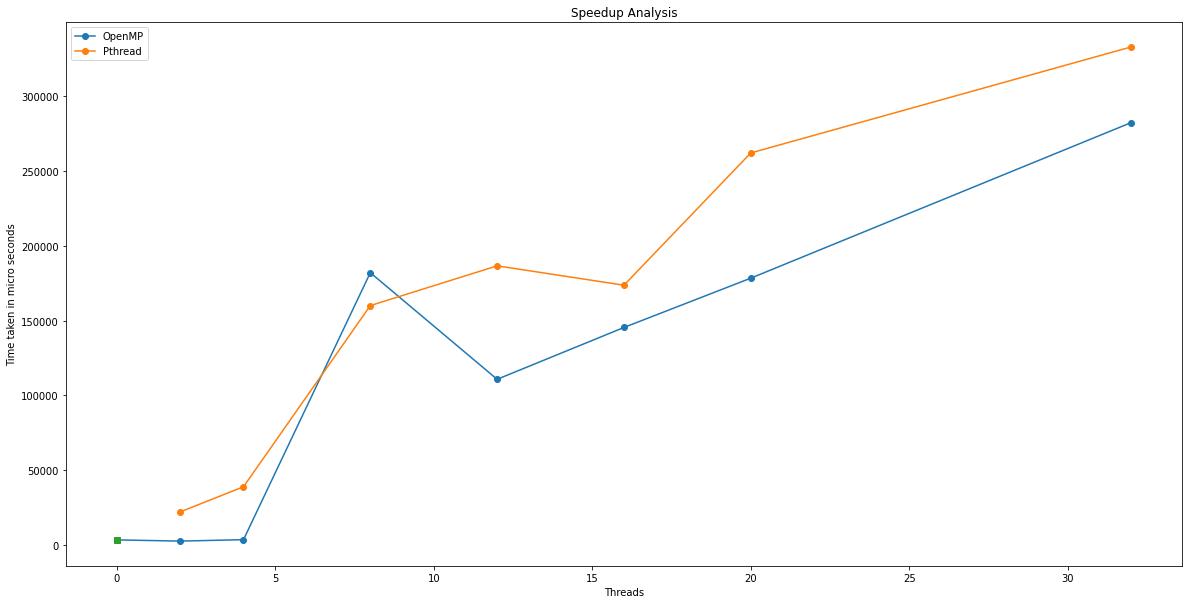

In [ ]:
plot_graph()

In [ ]:
%%script bash
rm openMP_times.txt
rm pthread_times.txt

In [ ]:
%%script bash
printf "\n SEQUENTIAL EXECUTION \n"
./sequential 500
printf "\n OPENMP EXECUTIONS \n"
./openMP 500 2
./openMP 500 4
./openMP 500 8
./openMP 500 12
./openMP 500 16
./openMP 500 20
./openMP 500 32
printf "\n PTHREAD EXECUTIONS \n"
./pthread 500 2
./pthread 500 4
./pthread 500 8
./pthread 500 12
./pthread 500 16
./pthread 500 20
./pthread 500 32


 SEQUENTIAL EXECUTION 
time taken by Sequential LU decomposition: 209532 micro seconds
Residue: 0.000000000000013915

 OPENMP EXECUTIONS 
time taken by parallel LU decomposition ( 500 | 2 ) : 153695 micro seconds
time taken by parallel LU decomposition ( 500 | 4 ) : 156306 micro seconds
time taken by parallel LU decomposition ( 500 | 8 ) : 299785 micro seconds
time taken by parallel LU decomposition ( 500 | 12 ) : 566543 micro seconds
time taken by parallel LU decomposition ( 500 | 16 ) : 647861 micro seconds
time taken by parallel LU decomposition ( 500 | 20 ) : 861430 micro seconds
time taken by parallel LU decomposition ( 500 | 32 ) : 1161389 micro seconds

 PTHREAD EXECUTIONS 
time taken by parallel LU decomposition ( 500 | 2 ) : 294981 micro seconds
time taken by parallel LU decomposition ( 500 | 4 ) : 233804 micro seconds
time taken by parallel LU decomposition ( 500 | 8 ) : 354548 micro seconds
time taken by parallel LU decomposition ( 500 | 12 ) : 453247 micro seconds
time tak

No. of Threads:  [0.0, 2.0, 4.0, 8.0, 12.0, 16.0, 20.0, 32.0]
Time taken by OpenMP:  [209532.0, 153695.0, 156306.0, 299785.0, 566543.0, 647861.0, 861430.0, 1161389.0]
No. of Threads:  [2.0, 4.0, 8.0, 12.0, 16.0, 20.0, 32.0]
Time taken by Pthread:  [294981.0, 233804.0, 354548.0, 453247.0, 553198.0, 647243.0, 951270.0]


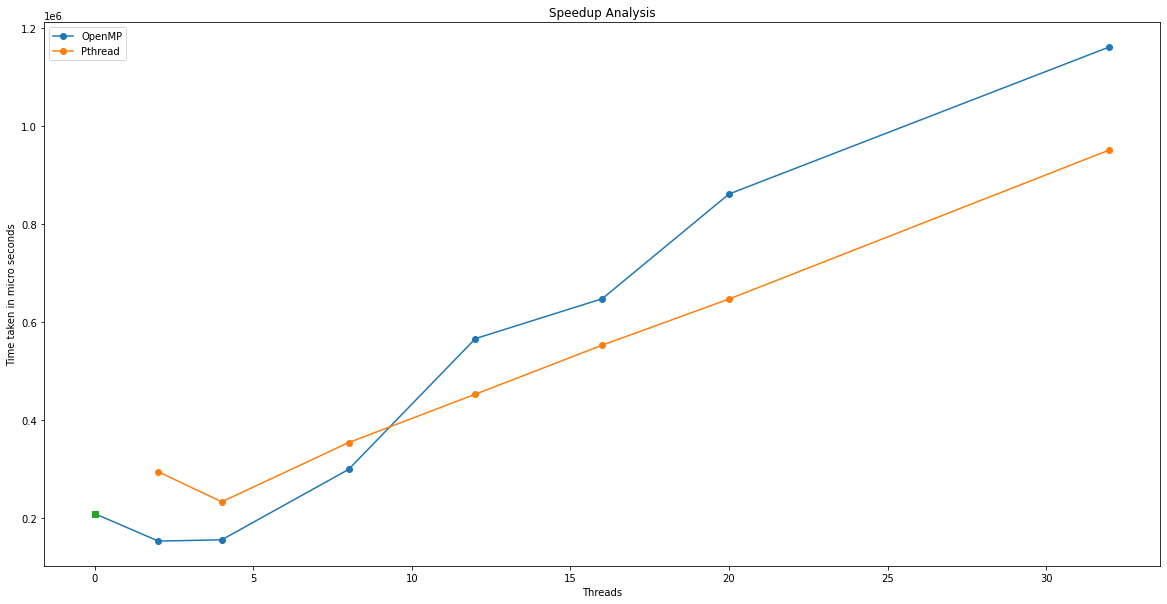

In [ ]:
plot_graph()

In [ ]:
%%script bash
rm openMP_times.txt
rm pthread_times.txt

In [ ]:
%%script bash
printf "\n SEQUENTIAL EXECUTION \n"
./sequential 1000
printf "\n OPENMP EXECUTIONS \n"
./openMP 1000 2
./openMP 1000 4
./openMP 1000 8
./openMP 1000 12
./openMP 1000 16
./openMP 1000 20
./openMP 1000 32
printf "\n PTHREAD EXECUTIONS \n"
./pthread 1000 2
./pthread 1000 4
./pthread 1000 8
./pthread 1000 12
./pthread 1000 16
./pthread 1000 20
./pthread 1000 32


 SEQUENTIAL EXECUTION 
time taken by Sequential LU decomposition: 1962122 micro seconds
Residue: 0.000000000000049095

 OPENMP EXECUTIONS 
time taken by parallel LU decomposition ( 1000 | 2 ) : 1438904 micro seconds
time taken by parallel LU decomposition ( 1000 | 4 ) : 889450 micro seconds
time taken by parallel LU decomposition ( 1000 | 8 ) : 1057391 micro seconds
time taken by parallel LU decomposition ( 1000 | 12 ) : 1570818 micro seconds
time taken by parallel LU decomposition ( 1000 | 16 ) : 1987263 micro seconds
time taken by parallel LU decomposition ( 1000 | 20 ) : 2046722 micro seconds
time taken by parallel LU decomposition ( 1000 | 32 ) : 3394466 micro seconds

 PTHREAD EXECUTIONS 
time taken by parallel LU decomposition ( 1000 | 2 ) : 2126634 micro seconds
time taken by parallel LU decomposition ( 1000 | 4 ) : 1573370 micro seconds
time taken by parallel LU decomposition ( 1000 | 8 ) : 1637587 micro seconds
time taken by parallel LU decomposition ( 1000 | 12 ) : 2192478 m

No. of Threads:  [0.0, 2.0, 4.0, 8.0, 12.0, 16.0, 20.0, 32.0]
Time taken by OpenMP:  [1962122.0, 1438904.0, 889450.0, 1057391.0, 1570818.0, 1987263.0, 2046722.0, 3394466.0]
No. of Threads:  [2.0, 4.0, 8.0, 12.0, 16.0, 20.0, 32.0]
Time taken by Pthread:  [2126634.0, 1573370.0, 1637587.0, 2192478.0, 2504750.0, 2814827.0, 2937819.0]


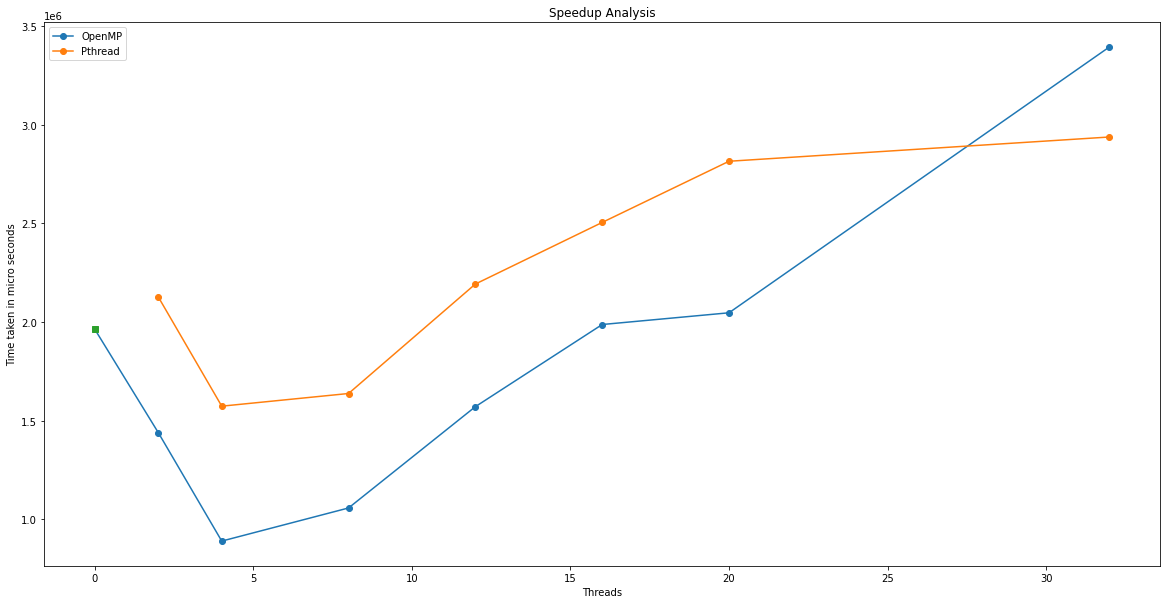

In [ ]:
plot_graph()

In [ ]:
%%script bash
rm openMP_times.txt
rm pthread_times.txt

In [ ]:
%%script bash
printf "\n SEQUENTIAL EXECUTION \n"
./sequential 2000
printf "\n OPENMP EXECUTIONS \n"
./openMP 2000 2
./openMP 2000 4
./openMP 2000 8
./openMP 2000 12
./openMP 2000 16
./openMP 2000 20
./openMP 2000 32
printf "\n PTHREAD EXECUTIONS \n"
./pthread 2000 2
./pthread 2000 4
./pthread 2000 8
./pthread 2000 12
./pthread 2000 16
./pthread 2000 20
./pthread 2000 32


 SEQUENTIAL EXECUTION 
time taken by Sequential LU decomposition: 15990630 micro seconds
Residue: 0.000000000000172378

 OPENMP EXECUTIONS 
time taken by parallel LU decomposition ( 2000 | 2 ) : 7529913 micro seconds
time taken by parallel LU decomposition ( 2000 | 4 ) : 5749451 micro seconds
time taken by parallel LU decomposition ( 2000 | 8 ) : 5023113 micro seconds
time taken by parallel LU decomposition ( 2000 | 12 ) : 6873729 micro seconds
time taken by parallel LU decomposition ( 2000 | 16 ) : 6950889 micro seconds
time taken by parallel LU decomposition ( 2000 | 20 ) : 7247613 micro seconds
time taken by parallel LU decomposition ( 2000 | 32 ) : 8590561 micro seconds

 PTHREAD EXECUTIONS 
time taken by parallel LU decomposition ( 2000 | 2 ) : 9356428 micro seconds
time taken by parallel LU decomposition ( 2000 | 4 ) : 6903572 micro seconds
time taken by parallel LU decomposition ( 2000 | 8 ) : 7392505 micro seconds
time taken by parallel LU decomposition ( 2000 | 12 ) : 8109796

No. of Threads:  [0.0, 2.0, 4.0, 8.0, 12.0, 16.0, 20.0, 32.0]
Time taken by OpenMP:  [15990630.0, 7529913.0, 5749451.0, 5023113.0, 6873729.0, 6950889.0, 7247613.0, 8590561.0]
No. of Threads:  [2.0, 4.0, 8.0, 12.0, 16.0, 20.0, 32.0]
Time taken by Pthread:  [9356428.0, 6903572.0, 7392505.0, 8109796.0, 8802177.0, 9240187.0, 9291388.0]


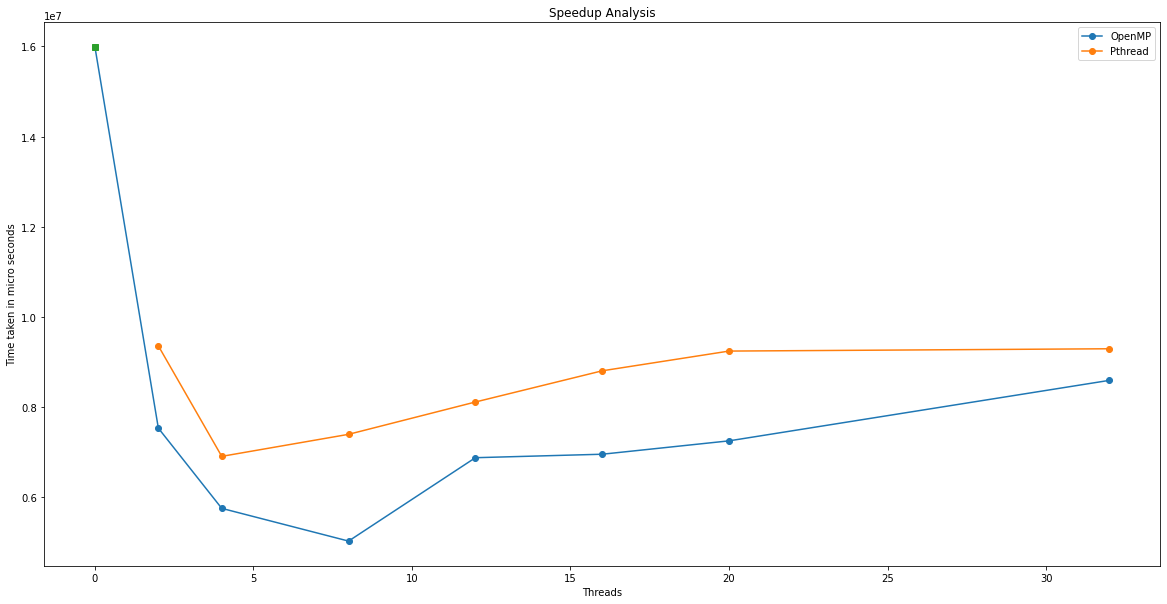

In [ ]:
plot_graph()

In [ ]:
%%script bash
rm openMP_times.txt
rm pthread_times.txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell
jupyter nbconvert --to html ///content/Parallel_Programming.ipynb

[NbConvertApp] Converting notebook ///content/Parallel_Programming.ipynb to html
[NbConvertApp] Writing 546149 bytes to ///content/Parallel_Programming.html
